In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [ ]:
stock_data = pd.read_csv('BSE_SENSEX.csv')
stock_data = stock_data[['Close']]

In [ ]:
# normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data)

# train and test datasets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [ ]:
# look back function
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
# reshape (lookback)
look_back = 60
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [ ]:
# lstm model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# compile, train and prediction
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=1, epochs=10)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


Epoch 1/10
1914/1914 [==============================] - 84s 42ms/step - loss: 0.0011
Epoch 2/10
1914/1914 [==============================] - 75s 39ms/step - loss: 4.4544e-04
Epoch 3/10
1914/1914 [==============================] - 76s 40ms/step - loss: 2.7498e-04
Epoch 4/10
1914/1914 [==============================] - 76s 40ms/step - loss: 2.0961e-04
Epoch 5/10
1914/1914 [==============================] - 75s 39ms/step - loss: 1.8000e-04
Epoch 6/10
1914/1914 [==============================] - 75s 39ms/step - loss: 1.8165e-04
Epoch 7/10
1914/1914 [==============================] - 77s 40ms/step - loss: 1.6827e-04
Epoch 8/10
1914/1914 [==============================] - 75s 39ms/step - loss: 1.6704e-04
Epoch 9/10
1914/1914 [==============================] - 76s 40ms/step - loss: 1.7795e-04
Epoch 10/10
14/14 [==============================] - 0s 22ms/step


In [ ]:
# Inverse transform predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])


In [ ]:
# RMSE
train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


Train RMSE: 507.8116790057832
Test RMSE: 1197.640517216204


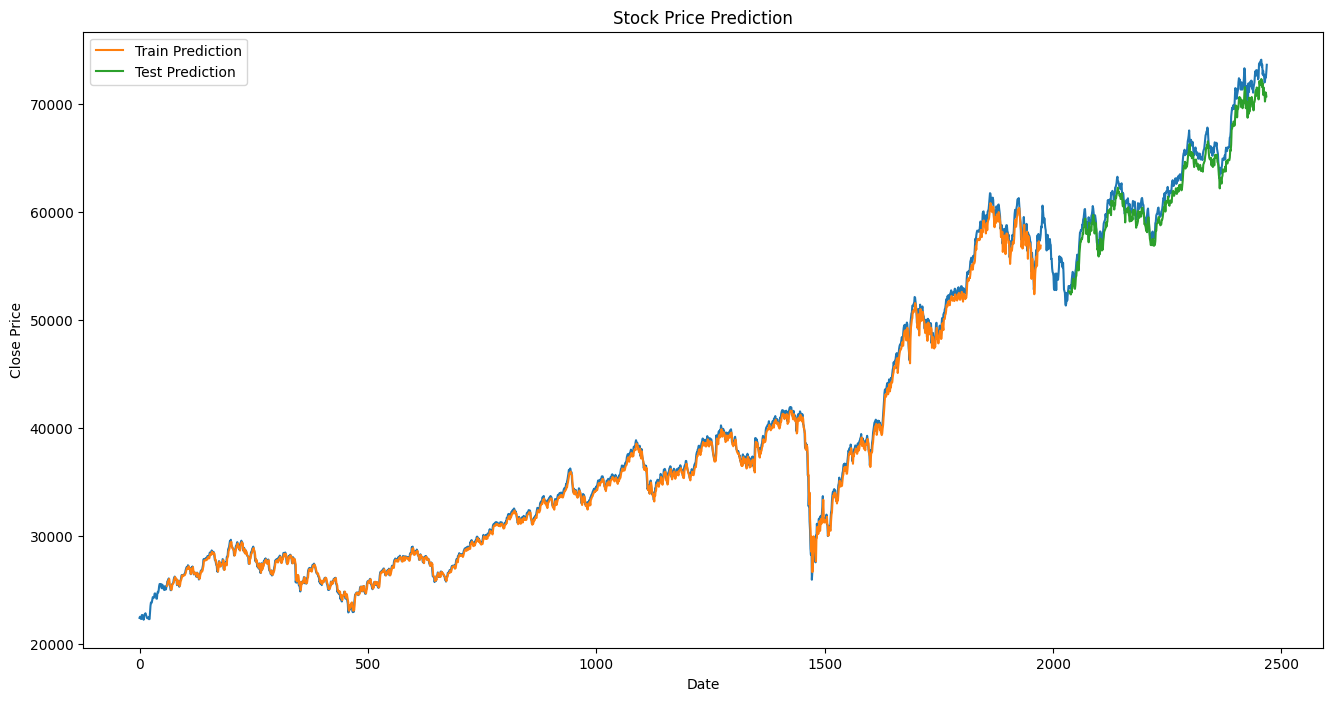

In [ ]:
# Plot the data
plt.figure(figsize=(16,8))
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(stock_data['Close'])
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(scaled_data)-1, :] = test_predict
plt.plot(train_predict_plot, label='Train Prediction')
plt.plot(test_predict_plot, label='Test Prediction')
plt.legend()
plt.show()


In [ ]:
# Mean Absolute Error
train_mae = mean_absolute_error(y_train[0], train_predict[:, 0])
test_mae = mean_absolute_error(y_test[0], test_predict[:, 0])

print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')

# Mean Squared Error
train_mse = mean_squared_error(y_train[0], train_predict[:, 0])
test_mse = mean_squared_error(y_test[0], test_predict[:, 0])

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')


Train MAE: 364.4967629963426
Test MAE: 1071.6687124711314
Train MSE: 257872.7013346726
Test MSE: 1434342.8084778967


Confusion Matrix:
[[ 80 105]
 [117 130]]


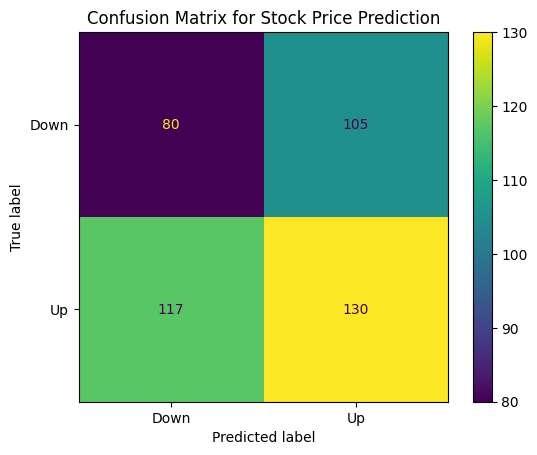

In [ ]:
# price to categories conversion.
def categorize(price):
    return np.where(price[1:] > price[:-1], 1, 0)

# initiating actual , predicted and trimmed categories.
actual_categories = categorize(stock_data['Close'].values)
predicted_categories = categorize(test_predict[:, 0])
trimmed_actual_categories = actual_categories[-len(predicted_categories):]

# Calculate confusion matrix
cm = confusion_matrix(trimmed_actual_categories, predicted_categories)
# display
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
disp.plot()
plt.title('Confusion Matrix for Stock Price Prediction')
plt.show()

In [ ]:
# calculating and printing performance metrics.
accuracy = accuracy_score(trimmed_actual_categories, predicted_categories)
precision = precision_score(trimmed_actual_categories, predicted_categories)
recall = recall_score(trimmed_actual_categories, predicted_categories)
f1 = f1_score(trimmed_actual_categories, predicted_categories)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.4861111111111111
Precision: 0.5531914893617021
Recall: 0.5263157894736842
F1 Score: 0.5394190871369294
